# SIRI accessibility analysis using UrbanAccess

[USDT UrbanAccess](https://github.com/UDST/urbanaccess) is a tool for GTFS transit and OSM pedestrian network accessibility analysis. We (ab)use this tool to do SIRI accessibility analysis.

The process has 2 steps - first, generate fake GTFS data from SIRI data, then use this fake data to create the accessibility data.

## Prerequisites

Install stride client with UrbanAccess dependencies:

```
pip install --upgrade open-bus-stride-client[urbanaccess]
```

## Set parameters

In [2]:
# each analysis has to be done on a single day given in this date
date = '2022-06-21'

# start / end hour within this date to analyse, should be minimal to reduce processing load
# hours are in UTC timezone
start_hour = 8
end_hour = 13

# geo bounding box to analyse
# comma-separated values min_lon, min_lat, max_lon, max_lat
# for example: 34.8, 31.96, 34.81, 31.97
# you can get it from - https://boundingbox.klokantech.com/ - use csv export

# the notebook ran with bbox for Tel Aviv:
# bbox = (34.732918,31.988688,34.876007,32.202171)
# but this takes a long time to generate, for testing you should use a smaller bbox
bbox = (34.8026307019,31.9610679309,34.8070885333,31.9646769735)

## Generate Fake GTFS data

In [5]:
import datetime

from stride.urbanaccess import create_fake_gtfs

# this can be used to test with a local stride API:
# import stride.config
# stride.config.STRIDE_API_BASE_URL = 'http://localhost:8080'

start_time = datetime.datetime.now()
print(f'start_time: {start_time}')

try:
    fake_gtfs_path = create_fake_gtfs.main(
        date=date, start_hour=start_hour, end_hour=end_hour, 
        bbox=','.join([str(v) for v in bbox])
    )
finally:
    end_time = datetime.datetime.now()
    print(f'end_time: {end_time}')
    print(f'duration: {(end_time-start_time).total_seconds()} seconds')

start_time: 2022-06-23 13:58:10.881531

creating fake gtfs data
target_path=.data/urbanaccess/fake_gtfs/2022-06-23T105810.881787
date: 2022-06-21
hours: 8 - 13
bbox: 34.732918,31.988688 - 34.876007,32.202171

100000 stop times...
200000 stop times...
{'routes': 936, 'stop_times': 228995, 'stops': 2905, 'trips': 11359}
Fake gtfs data successfully stored at ".data/urbanaccess/fake_gtfs/2022-06-23T105810.881787"
end_time: 2022-06-23 14:43:10.440828
duration: 2699.559297 seconds


## Create the accessibility network

In [6]:
from stride.urbanaccess import create_network

network_path = create_network.main(fake_gtfs_path=fake_gtfs_path)


Creating urbanaccess network
fake_gtfs_path=.data/urbanaccess/fake_gtfs/2022-06-23T105810.881787
target_path=.data/urbanaccess/network/2022-06-23T124844.071251

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.02 seconds
--------------------------------
Processing GTFS feed: siri_feed
The agency.txt or agency_id column was not found. The unique agency id: siri_feed was generated using the name of the folder containing the GTFS feed text files.
Unique agency id operation complete. Took 0.01 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Appended route type to stops
Appended route type to stop_times
--------------------------------
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 0.41 seconds
1 GTFS feed file(s) successfully read as dataframes:
     siri_feed
     Took 0.86 seconds
Using calendar 

## Analyse the network

The generated network can now be loaded from disk to do some analysis, see https://github.com/UDST/urbanaccess for more details regarding how to use this data. Following analysis is based on http://simplistic.me/urbanaccess-tel-aviv-demo.html

### Load the saved network

In [1]:
import stride.urbanaccess.helpers

urbanaccess_net = stride.urbanaccess.helpers.load_network(network_path)

Successfully read store: .data/urbanaccess/network/2022-06-23T124844.071251/final_net.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: .data/urbanaccess/network/2022-06-23T124844.071251/final_net.h5 with the following keys: ['/edges', '/nodes']


### Visualize the network

Plot a map where darker red means slower travel times

Figure created. Took 15.91 seconds


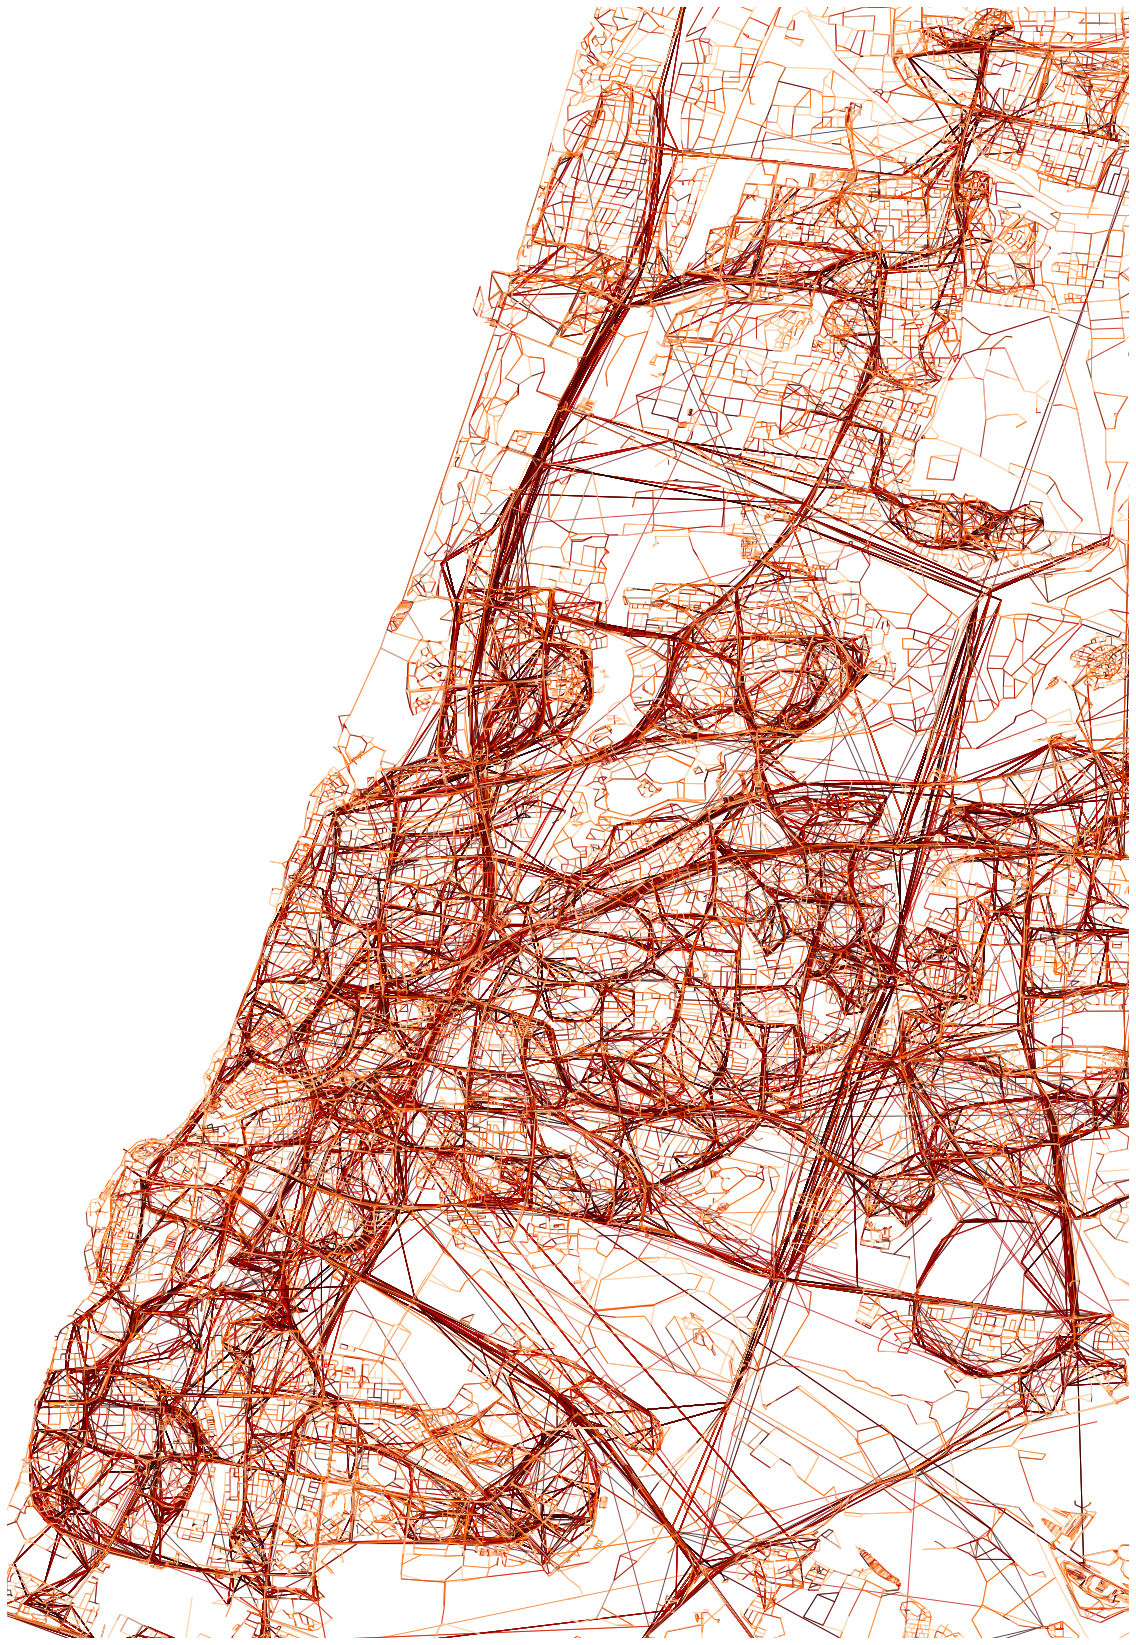

(<Figure size 1447.76x2160 with 1 Axes>, <AxesSubplot:>)

In [4]:
import urbanaccess.plot

edgecolor = urbanaccess.plot.col_colors(df=urbanaccess_net.net_edges, col='weight', cmap='gist_heat_r', num_bins=5)
urbanaccess.plot.plot_net(
    nodes=urbanaccess_net.net_nodes,
    edges=urbanaccess_net.net_edges,
    bbox=bbox,
    fig_height=30, margin=0.02,
    edge_color=edgecolor, edge_linewidth=1, edge_alpha=0.7,
    node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False
)